# Solución Ejercicio 2 - Autoevaluación 2024 - Clasificación Pizza/ No Pizza


-   **Autores:** Alfonso Carabantes Álamo
-   **Fecha:** Julio 2024

------------------------------------------------------------------------



## Introducción

Para la resolución de este ejercicio usaremos la Base de datos obtenida
de:

<https://www.google.com/url?sa=D&q=https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz>

Esta base de datos contiene imágenes de 5 tipos de flores, el objetivo
del ejercicio es construir un clasificador que nos de el mejor resultado
posible usando diferentes arquitecturas y técnicas de trabajo.

Dentro del fichero nos encontramos con:

-   daisy - 633
-   dandelion - 898
-   roses - 641
-   sunflowers - 699
-   tulips - 799

Deberemos crear nuestras carpetas de **entrenamiento**, **validación** y
**test**.

Usaremos durante el entrenamiento los datos de entrenamiento y
validación y luego finalmente para ese modelo **evaluaremos** el modelo
con los datos de test.

Durante el ejercicio, vamos a intentar usar diferentes técnicas para ver
si podemos conseguir mejorar los resultados de precisión de nuestro
entrenamiento.

Plantearemos diferentes modelos con complejidades y configuraciones
diferentes en cuanto a la arquitectura, y también veremos como usar el
**Data Augmentation**, en este caso generando los nuevos gráficos de
forma estática en lugar de online mientras se ejecuta el entrenamiento.
Otro de las técnicas que usaremos será el trabajo con una red
**preentrenada**, configurando un **Feature Extraction** y **Fine
Tuning**.

Para la resolución del ejercicio hemos construido una serie de
**funciones** que nos permitirán tener un código más limpio,
reutilizable y que sea más fácil seguir el flujo del trabajo. Estas
funciones están en un fichero aparte (aunque se mostrarán al final de la
documentación del ejercicio).



# Información de versiones e Importación de funciones propias

Presentamos información de las versiones usadas de Python y tensorflow, además definir todas las funciones que luego usamos para no estar escribiendo todo el rato el mismo código.

In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

import tensorflow as tf
print(tf.__version__)

Python version
3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:04:44) [MSC v.1940 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=12, micro=4, releaselevel='final', serial=0)
2.17.0


Importamos todos los módulos que vamos a usar así como las funciones que hemos creado.

In [ ]:
import os
import sys
import tensorflow as tf
import sys
import pathlib
import tarfile
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
import random

# Función para descargar el dataset y descomprimirlo
def carga_dataset():
  import pathlib
  dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
  # Hay que revisar el data_dir que no sirve para nada!!!!!
  global data_dir 
  data_dir = tf.keras.utils.get_file(origin=dataset_url,fname='/content/flower_photos.tgz', extract=True, archive_format='tar')
  data_dir = pathlib.Path(data_dir)
  my_tar = tarfile.open('/content/flower_photos.tgz')
  my_tar.extractall('.')
  my_tar.close()

# Función para preparar los directorios con las imágenes
def prepara_directorios():
  global original
  global base_dir
  global train_dir
  global val_dir
  global test_dir
  global ficheros_daisy
  global ficheros_dandelion
  global ficheros_roses
  global ficheros_sunflowers
  global ficheros_tulips
  original = "./flower_photos"
  base_dir = "./flores"
  train_dir = "./flores/train"
  val_dir = "./flores/val"
  test_dir = "./flores/test"
  # Directorios base
  os.mkdir(base_dir)
  os.mkdir(train_dir)
  os.mkdir(val_dir)
  os.mkdir(test_dir)
  # Directoriso para cada tipo de flor en cada bloque
  os.mkdir(train_dir + "/daisy")
  os.mkdir(train_dir + "/dandelion")
  os.mkdir(train_dir + "/roses")
  os.mkdir(train_dir + "/sunflowers")
  os.mkdir(train_dir + "/tulips")
  os.mkdir(val_dir + "/daisy")
  os.mkdir(val_dir + "/dandelion")
  os.mkdir(val_dir + "/roses")
  os.mkdir(val_dir + "/sunflowers")
  os.mkdir(val_dir + "/tulips")
  os.mkdir(test_dir + "/daisy")
  os.mkdir(test_dir + "/dandelion")
  os.mkdir(test_dir + "/roses")
  os.mkdir(test_dir + "/sunflowers")
  os.mkdir(test_dir + "/tulips")
  # Nos quedamos en cada vector con los nombres de los ficheros
  # de imágenes en cada directorio
  ficheros_daisy = os.listdir(original + "/daisy") 
  ficheros_dandelion = os.listdir(original + "/dandelion")
  ficheros_roses = os.listdir(original + "/roses") 
  ficheros_sunflowers = os.listdir(original + "/sunflowers") 
  ficheros_tulips = os.listdir(original + "/tulips")
  # Copiamos las imágenes de entrenamiento
  for i in range(1,506):
    shutil.copy(original+"/daisy/"+ficheros_daisy[i], train_dir+ "/daisy" )
    shutil.copy(original+"/dandelion/"+ficheros_dandelion[i], train_dir+ "/dandelion" )
    shutil.copy(original+"/roses/"+ficheros_roses[i], train_dir+ "/roses" )
    shutil.copy(original+"/sunflowers/"+ficheros_sunflowers[i], train_dir+ "/sunflowers" )
    shutil.copy(original+"/tulips/"+ficheros_tulips[i], train_dir+ "/tulips" )
  # Copiamos las imágenes de valicación
  for i in range(507,569):
    shutil.copy(original+"/daisy/"+ficheros_daisy[i], val_dir + "/daisy" )
    shutil.copy(original+"/dandelion/"+ficheros_dandelion[i], val_dir + "/dandelion" )
    shutil.copy(original+"/roses/"+ficheros_roses[i], val_dir + "/roses" )
    shutil.copy(original+"/sunflowers/"+ficheros_sunflowers[i], val_dir + "/sunflowers" )
    shutil.copy(original+"/tulips/"+ficheros_tulips[i], val_dir + "/tulips" )
    # Copiamos las imágenes de test
  for i in range(570,632):
    shutil.copy(original+"/daisy/"+ficheros_daisy[i], test_dir + "/daisy" )
    shutil.copy(original+"/dandelion/"+ficheros_dandelion[i], test_dir + "/dandelion" )
    shutil.copy(original+"/roses/"+ficheros_roses[i], test_dir + "/roses" )
    shutil.copy(original+"/sunflowers/"+ficheros_sunflowers[i], test_dir + "/sunflowers" )
    shutil.copy(original+"/tulips/"+ficheros_tulips[i], test_dir + "/tulips" )

# Función para la creación de los generadores de imágenes
# Se encargan de leer de los directorios y hacer transformaciones
def crea_generadores_imagenes():
  global training_image_flow
  global validation_image_flow
  global test_image_flow
  global trainning_generator
  global validation_generator
  global test_generator
  # Los generadores básicos simplemente divien el valor entre 255
  # Así todo son valores entre 0 y 1
  trainning_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
  validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
  # Vamos a leer del directiro adecuado
  # Indicamos que es de tipo categorical
  # Tamaño de las imágenes que nos quedaremos al tratarlas (las transforma)
  # Tamaño del batch de processamiento
  training_image_flow = trainning_generator.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=(150, 150),
    batch_size=32)
  validation_image_flow = validation_generator.flow_from_directory(
    directory = val_dir,
    class_mode = "categorical",
    batch_size = 32,
    target_size = (150, 150))
  test_image_flow = test_generator.flow_from_directory(
    directory = test_dir,
    class_mode = "categorical",
    batch_size = 32,
    target_size = (150, 150),
    shuffle = False)
  
# Función para la visuación aleatoria de una imagen
# de cada tipo de flor
def visualiza_imagenes_random():
  print(ficheros_daisy[0])
  pyplot.subplot(330 + 1)
  filename = train_dir + '/daisy/' + ficheros_daisy[random.randint(0, 100)]
  image = imread(filename)
  pyplot.imshow(image)
  pyplot.subplot(330 + 2)
  filename = train_dir + '/dandelion/' + ficheros_dandelion[random.randint(0, 100)]
  image = imread(filename)
  pyplot.imshow(image)
  pyplot.subplot(330 + 3)
  filename = train_dir + '/roses/' + ficheros_roses[random.randint(0, 100)]
  image = imread(filename)
  pyplot.imshow(image)
  pyplot.subplot(330 + 4)
  filename = train_dir + '/sunflowers/' + ficheros_sunflowers[random.randint(0, 100)]
  image = imread(filename)
  pyplot.imshow(image)
  pyplot.subplot(330 + 5)
  filename = train_dir + '/tulips/' + ficheros_tulips[random.randint(0, 100)]
  image = imread(filename)
  pyplot.imshow(image)
  pyplot.show()

# Función para la creación del modelo 1
def crea_modelo_1():
  modelo = keras.Sequential()
  # input_shape es 150x150 porque se lo decimos en los generadores
  modelo.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))
  modelo.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  # Número de neuronas de salida son 5, ya que hay 5 clases
  # Usamos la activación softmax
  modelo.add(keras.layers.Dense(5, activation='softmax'))
  # Usamos el optimizador adadm junto con
  # la función de pérdida de Crossentropy
  # y la métrica de Accuracy
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

# Función para la creación del modelo 2
def crea_modelo_2():
  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.Dense(5, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

# Función para la creación del modelo 3
def crea_modelo_3():
  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  # Añadimos BatchNormalización
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  # Añadimos Regulación Dropout
  modelo.add(tf.keras.layers.Dropout(.2))
  modelo.add(keras.layers.Dense(5, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

# Función para la creación del modelo 4
def crea_modelo_4():
  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(tf.keras.layers.Dropout(.2))
  modelo.add(keras.layers.Dense(5, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

# Función que entrena el modelo que le pasemos
# Le asignamos el flujo de entrada de entranamiento y validación
# Ponemos 10 iteraciones
def entrena_modelo(modelo):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  history = modelo.fit(
    training_image_flow,
    epochs = 10,
    validation_data = validation_image_flow )
  return history

 # Función para ver el gráfico de evolución del entranmiento
 # Muestra los valores de las métricas y función de pérdida
 # tanto en entrenamiento como en validación              
def muestra_historico_entrenamiento(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(10)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Función para guardar el modelo
def guarda_modelo(modelo, nombre_modelo):
  modelo.save(nombre_modelo)

# Función para cargar el modelo
def carga_modelo(nombre_modelo):
  modelo = tf.keras.models.load_model(nombre_modelo)
  return modelo

# Función que evalua el modelo con los datos de test
# Mostramos el valor de la función de pérdida y la métrica
# para los valores de test
def evalua_modelo(modelo):
  evalua = modelo.evaluate(test_image_flow,
                                     steps = 10)
  return evalua

def matriz_confusion(modelo):
  from sklearn.metrics import confusion_matrix
  import numpy as np
  import seaborn as sn
  import pandas as pd
  import matplotlib.pyplot as plt
  predicciones = modelo.predict( test_image_flow)
  y_pred = np.argmax(predicciones, axis=1)
  print(test_image_flow.class_indices)
  class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

  df_cm = pd.DataFrame(confusion_matrix(test_image_flow.classes, y_pred))
  # plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size": 16}) # font size

  plt.show()

# Descarga de las imágenes

Vamos automatizar la descarga de las imágenes que vamos a usar.

In [ ]:
carga_dataset()

228827136/228813984 [==============================] - 2s 0us/step


# Preparación directorios de trabajo

Pasamos a preparar los directorios de trabajo y visualizamos cuantas
imágenes hay en cada directorio. Construimos un directorio **flores** de
donde colgarán nuestros directorios **train**, **val** y **test** y cada
uno de ellos con sus directorios **daisy**, **dandelion**, **roses**,
**sunflowers** y **tulips**. Para hacer el reparto de imágenes cogemos
el **80%** para train, el **10%** para val y el otro **10%** para test.
Como hay diferente cantidad de imágenes en cada tipo de flor lo hemos
unificado y hemos dejado el mismo número en todas las muestras.

In [ ]:
prepara_directorios()


Como vamos a usar imágenes que están en nuestro sistema de archivos,
vamos a preparar para que le red neuronal pueda ir leyendo la
información desde los directorios. También usaremos esta parte para
estandarizar el tamaño de las imágenes a un tamaño de 150x150.

Mostramos también cada clase a que valor corresponde.

In [ ]:
crea_generadores_imagenes()

Found 2525 images belonging to 5 classes.
Found 310 images belonging to 5 classes.
Found 310 images belonging to 5 classes.


# Visualización de Imágenes

Vamos a mostrar varias imágenes de entrenamiento.

9094631844_1a6abca29e.jpg


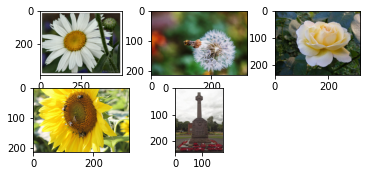

In [ ]:
visualiza_imagenes_random()


Vamos a pasar a ver los diferentes modelos que vamos a probar.

# Modelo 1 ( 32,64, adam)

En este modelo vamos a tener:

-   Capa **convolución** con 32 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa para **aplanar** la información
-   Capa **dénsamente** conectada de 512 neuronas y activación **relu**
-   Capa de **salida** de 5 neurona y activación **softmax** que nos da
    la clasificación

## Creamos el modelo


In [ ]:
modelo_1 = crea_modelo_1()
modelo_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               44859904  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2

## Entrenamos el modelo

In [ ]:

history_1 = entrena_modelo(modelo_1)

Epoch 1/10
79/79 [==============================] - 39s 144ms/step - loss: 1.7572 - accuracy: 0.4170 - val_loss: 1.2017 - val_accuracy: 0.4806
Epoch 2/10
79/79 [==============================] - 11s 133ms/step - loss: 1.0314 - accuracy: 0.5945 - val_loss: 1.2421 - val_accuracy: 0.5290
Epoch 3/10
79/79 [==============================] - 10s 132ms/step - loss: 0.6435 - accuracy: 0.7651 - val_loss: 1.1367 - val_accuracy: 0.5258
Epoch 4/10
79/79 [==============================] - 11s 133ms/step - loss: 0.3200 - accuracy: 0.8962 - val_loss: 1.2545 - val_accuracy: 0.5871
Epoch 5/10
79/79 [==============================] - 11s 133ms/step - loss: 0.1308 - accuracy: 0.9600 - val_loss: 1.8535 - val_accuracy: 0.5516
Epoch 6/10
79/79 [==============================] - 11s 133ms/step - loss: 0.0941 - accuracy: 0.9782 - val_loss: 1.7234 - val_accuracy: 0.5710
Epoch 7/10
79/79 [==============================] - 11s 133ms/step - loss: 0.0341 - accuracy: 0.9917 - val_loss: 2.0051 - val_accuracy: 0.5677

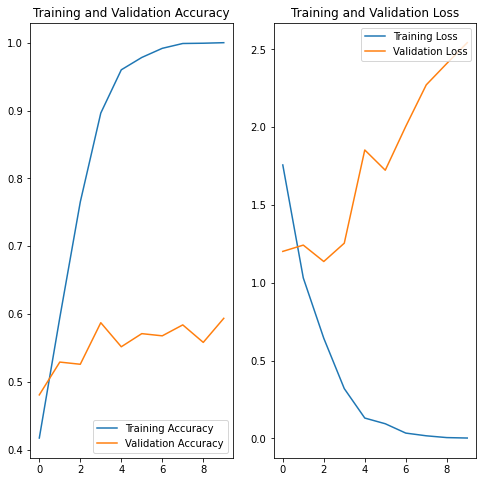

In [ ]:
muestra_historico_entrenamiento(history_1)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_1,"modelo_1_flores")

INFO:tensorflow:Assets written to: modelo_1_flores/assets


## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_1 = carga_modelo("modelo_1_flores")
evalua_1 = evalua_modelo(modelo_1)
print(evalua_1)

10/10 [==============================] - 1s 113ms/step - loss: 2.4710 - accuracy: 0.5968
[2.471039295196533, 0.5967742204666138]


## Matriz de Confusión de los datos de test

Mostramos la matriz de confusión para los datos de test del modelo cargado.

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


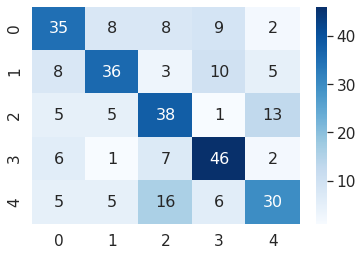

In [ ]:
matriz_confusion(modelo_1)

# Modelo 2 ( 64,128, 128 adam)

Ampliamos el modelo con una capa de convolución y pooling más y mayor
número de filtros

En este modelo vamos a tener:

-   Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa para **aplanar** la información
-   Capa **dénsamente** conectada de 512 neuronas y activación **relu**
-   Capa de **salida** de 5 neurona y activación **softmax** que nos da
    la clasificación
-   Optimizador **adam**

## Creamos el modelo

In [ ]:
modelo_2 = crea_modelo_2()
modelo_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)            

## Entrenamos el modelo

In [ ]:
history_2 = entrena_modelo(modelo_2)

Epoch 1/10
79/79 [==============================] - 14s 157ms/step - loss: 1.4191 - accuracy: 0.4253 - val_loss: 1.1437 - val_accuracy: 0.5355
Epoch 2/10
79/79 [==============================] - 11s 141ms/step - loss: 1.0149 - accuracy: 0.5984 - val_loss: 1.0282 - val_accuracy: 0.5774
Epoch 3/10
79/79 [==============================] - 11s 141ms/step - loss: 0.8331 - accuracy: 0.6848 - val_loss: 0.9500 - val_accuracy: 0.6097
Epoch 4/10
79/79 [==============================] - 11s 142ms/step - loss: 0.6674 - accuracy: 0.7477 - val_loss: 0.8693 - val_accuracy: 0.6581
Epoch 5/10
79/79 [==============================] - 11s 141ms/step - loss: 0.4605 - accuracy: 0.8265 - val_loss: 1.0313 - val_accuracy: 0.5968
Epoch 6/10
79/79 [==============================] - 11s 141ms/step - loss: 0.2948 - accuracy: 0.8966 - val_loss: 1.2710 - val_accuracy: 0.6097
Epoch 7/10
79/79 [==============================] - 11s 141ms/step - loss: 0.1486 - accuracy: 0.9545 - val_loss: 1.3910 - val_accuracy: 0.6516

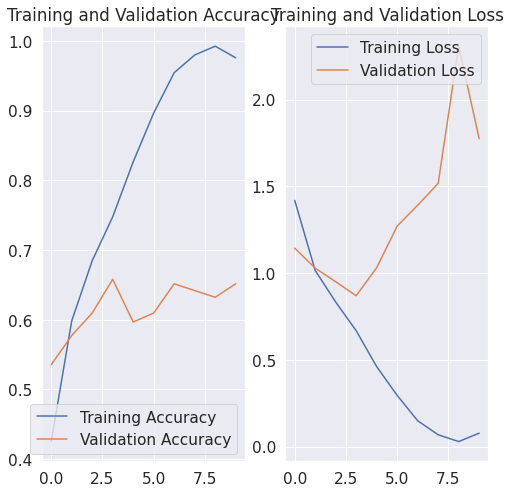

In [ ]:
muestra_historico_entrenamiento(history_2)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo( modelo_2, "modelo_2_flores")

INFO:tensorflow:Assets written to: modelo_2_flores/assets


## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_2 = carga_modelo("modelo_2_flores")
evalua_2 = evalua_modelo(modelo_2)
print(evalua_2)

10/10 [==============================] - 1s 118ms/step - loss: 1.9050 - accuracy: 0.6613
[1.905025601387024, 0.6612903475761414]


## Matriz de Confusión de los datos de test

Mostramos la matriz de confusión para los datos de test del modelo cargado.

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


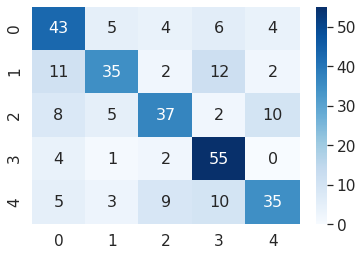

In [ ]:
matriz_confusion(modelo_2)

# Modelo 3 ( 64,128, 128 adam Dropout BatchNormalization)

Vamos a construir ahora un modelo más complejo en el que vamos a añadir
más filtros, así como regularización mediante dropout para conseguir
mejor generalización.

En este modelo vamos a tener: 
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **pooling** tipo maxpooling de tamaño 2x2 
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** - Capa de **pooling** tipo maxpooling de tamaño
2x2 
- Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **pooling** tipomaxpooling de tamaño 2x2 
- Capa para **aplanar** la información 
- Capa **dénsamente** conectada de 512 neuronas y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **dropout** quitando el 25% de las neuronas. 
- Capa de **salida** de 5 neuronas y activación **softmax** que nos da la clasificación

## Creamos el modelo

In [ ]:
modelo_3 = crea_modelo_3()
modelo_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)      

## Entrenamos el modelo

In [ ]:
history_3 = entrena_modelo(modelo_3)

Epoch 1/10
79/79 [==============================] - 14s 157ms/step - loss: 1.4769 - accuracy: 0.5307 - val_loss: 3.4624 - val_accuracy: 0.2000
Epoch 2/10
79/79 [==============================] - 12s 154ms/step - loss: 0.8231 - accuracy: 0.6994 - val_loss: 3.7430 - val_accuracy: 0.2000
Epoch 3/10
79/79 [==============================] - 12s 156ms/step - loss: 0.5707 - accuracy: 0.7960 - val_loss: 2.7879 - val_accuracy: 0.2258
Epoch 4/10
79/79 [==============================] - 12s 153ms/step - loss: 0.3898 - accuracy: 0.8709 - val_loss: 2.2512 - val_accuracy: 0.3000
Epoch 5/10
79/79 [==============================] - 12s 155ms/step - loss: 0.2390 - accuracy: 0.9255 - val_loss: 1.7939 - val_accuracy: 0.4032
Epoch 6/10
79/79 [==============================] - 12s 150ms/step - loss: 0.1973 - accuracy: 0.9323 - val_loss: 1.7774 - val_accuracy: 0.4903
Epoch 7/10
79/79 [==============================] - 12s 152ms/step - loss: 0.1715 - accuracy: 0.9469 - val_loss: 1.8543 - val_accuracy: 0.4581

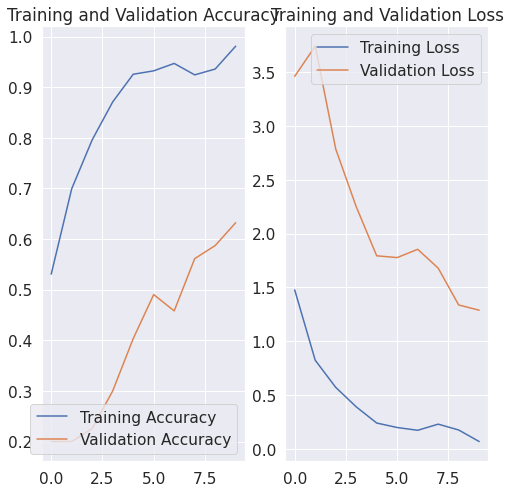

In [ ]:
muestra_historico_entrenamiento(history_3)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_3,"modelo_3_flores")

INFO:tensorflow:Assets written to: modelo_3_flores/assets


## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_3 = carga_modelo("modelo_3_flores")
evalua_3 = evalua_modelo(modelo_3)
print(evalua_3)


10/10 [==============================] - 2s 120ms/step - loss: 1.2816 - accuracy: 0.6355
[1.281569004058838, 0.6354838609695435]


## Matriz de Confusión de los datos de test

Mostramos la matriz de confusión para los datos de test del modelo cargado.

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


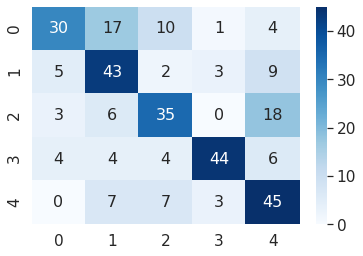

In [ ]:
matriz_confusion(modelo_3)

# Modelo 4 ( 64,128, 128 adam Dropout BatchNormalization Augmentation)

Vamos a aplicar la técnica del **Data Augmentation** a nuestro conjuto
de imágenes. De esta manera, con las transformaciones a las imágenes conseguiremos imágenes "nuevas" para poder tener más imágenes para entrenar nuestro modelo y poder conseguir que generalice mejor (no haya tanto sobreajuste).
En cuanto la arquitectura seguiremos manteniendo la misma que teníamos.

## Matriz de Confusión de los datos de test

Mostramos la matriz de confusión para los datos de test del modelo cargado.

## Creamos el modelo

In [ ]:
modelo_4 = crea_modelo_4()
modelo_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 128)      

## Entrenamos el modelo

Usamos el data augmentation para generar las nuevas imágenes durante el entrenamiento.

In [ ]:
trainning_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

training_image_flow = trainning_generator.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=(150, 150),
    batch_size=32)
  
history_4 = entrena_modelo(modelo_4)

Found 2525 images belonging to 5 classes.
Epoch 1/10
79/79 [==============================] - 26s 313ms/step - loss: 1.7986 - accuracy: 0.4891 - val_loss: 4.0247 - val_accuracy: 0.2000
Epoch 2/10
79/79 [==============================] - 24s 309ms/step - loss: 1.1434 - accuracy: 0.5675 - val_loss: 1.8900 - val_accuracy: 0.2516
Epoch 3/10
79/79 [==============================] - 24s 307ms/step - loss: 1.0229 - accuracy: 0.6123 - val_loss: 2.1230 - val_accuracy: 0.2903
Epoch 4/10
79/79 [==============================] - 24s 306ms/step - loss: 0.9828 - accuracy: 0.6253 - val_loss: 1.5594 - val_accuracy: 0.3871
Epoch 5/10
79/79 [==============================] - 24s 307ms/step - loss: 0.8787 - accuracy: 0.6669 - val_loss: 1.4416 - val_accuracy: 0.4516
Epoch 6/10
79/79 [==============================] - 24s 303ms/step - loss: 0.8403 - accuracy: 0.6800 - val_loss: 1.1356 - val_accuracy: 0.5613
Epoch 7/10
79/79 [==============================] - 24s 304ms/step - loss: 0.8003 - accuracy: 0.6875

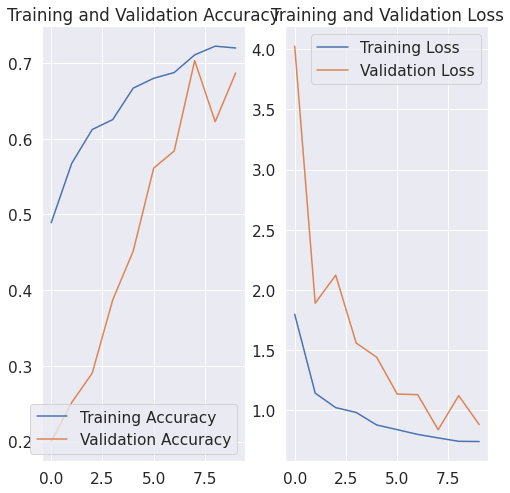

In [ ]:
muestra_historico_entrenamiento(history_4)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_4,"modelo_4_flores")

INFO:tensorflow:Assets written to: modelo_4_flores/assets


## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_4 = carga_modelo("modelo_4_flores")
evalua_4 = evalua_modelo(modelo_4)
print(evalua_4)

10/10 [==============================] - 1s 115ms/step - loss: 0.9374 - accuracy: 0.6968
[0.937390148639679, 0.6967741847038269]


## Matriz de Confusión de los datos de test

Mostramos la matriz de confusión para los datos de test del modelo cargado.

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


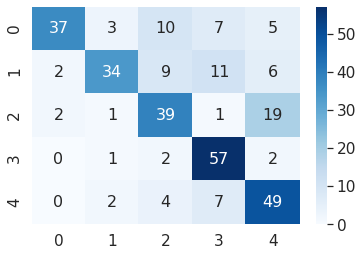

In [ ]:
matriz_confusion(modelo_4)

# Modelo 5 Uso de Red Preentrenado Feature Extraction

Vamos a usar una red **Pre-Entrenada** para implementar el clasificador,
en este caso usaremos la red **VGG16**. Usaremos la técnica de
**Extracción de features** que nos permite quitar de la red
convolucional la parte final del clasificador y poner la nuestra para la
clasificación binaria que queremos hacer. Hay que tener en cuenta que
esta red neuronal está pre-entrenada sobre más de 1 millón de imágenes
(ttp://www.image-net.org) y categoriza en 1.000 categorías.


La extracción de características consiste en utilizar las
representaciones aprendidas por una red anterior para extraer
características interesantes de nuevas muestras.

Estas características se ejecutan a través de un nuevo clasificador, que
se entrena desde cero.

Vamos a instanciar una red preentrenada **VGG16** que es una de las
redes que vienen incluidas en Keras.


In [ ]:
# Modelo base
# se descargan los pesos de esta red pre-entrenada para poderla usar
# Indicamos que el input_shape es de 150x150
# No incluimos la parte final include_top = False porque la crearemos  nosotros
modelo_base_vgg16 = tf.keras.applications.VGG16( weights='imagenet', input_shape=(150, 150, 3),include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


Construimos el modelo añadiendo la capa de clasificación que nosotros
necesitamos, además de **congelar (no entrenable)** los parámetros ya entrenados de
**VGG16**.

In [ ]:
# Indicamos que nuestro modelos base no se tiene que entrenar
modelo_base_vgg16.trainable = False

# Construimos el modelo, añadiendo nuestra parte final
modelo_5 = keras.Sequential()
modelo_5.add(modelo_base_vgg16)
modelo_5.add(keras.layers.Flatten())
modelo_5.add(keras.layers.Dense(256, activation='relu'))
modelo_5.add(keras.layers.Dense(5, activation='softmax'))
modelo_5.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
modelo_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


## Entrenamos el modelo

In [ ]:
history_5 = entrena_modelo(modelo_5)

Epoch 1/10
79/79 [==============================] - 39s 421ms/step - loss: 0.9796 - accuracy: 0.6424 - val_loss: 0.8128 - val_accuracy: 0.7065
Epoch 2/10
79/79 [==============================] - 26s 323ms/step - loss: 0.6685 - accuracy: 0.7549 - val_loss: 0.6485 - val_accuracy: 0.7742
Epoch 3/10
79/79 [==============================] - 25s 321ms/step - loss: 0.6242 - accuracy: 0.7747 - val_loss: 0.6304 - val_accuracy: 0.7742
Epoch 4/10
79/79 [==============================] - 26s 322ms/step - loss: 0.5308 - accuracy: 0.8135 - val_loss: 0.5763 - val_accuracy: 0.8097
Epoch 5/10
79/79 [==============================] - 25s 320ms/step - loss: 0.4948 - accuracy: 0.8174 - val_loss: 0.6260 - val_accuracy: 0.8032
Epoch 6/10
79/79 [==============================] - 25s 319ms/step - loss: 0.4767 - accuracy: 0.8186 - val_loss: 0.6126 - val_accuracy: 0.8097
Epoch 7/10
79/79 [==============================] - 25s 319ms/step - loss: 0.4357 - accuracy: 0.8420 - val_loss: 0.6758 - val_accuracy: 0.7710

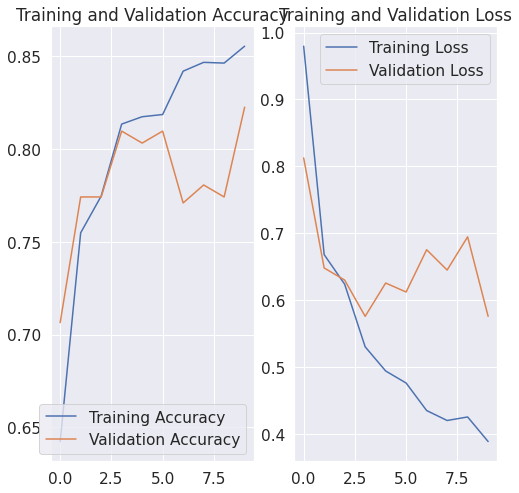

In [ ]:
muestra_historico_entrenamiento(history_5)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_5,"modelo_5_flores")

INFO:tensorflow:Assets written to: modelo_5_flores/assets


## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_5 = carga_modelo("modelo_5_flores")
evalua_5 = evalua_modelo(modelo_5)
print(evalua_5)

10/10 [==============================] - 2s 152ms/step - loss: 0.5962 - accuracy: 0.8129
[0.596211850643158, 0.8129032254219055]


## Matriz de Confusión de los datos de test

Mostramos la matriz de confusión para los datos de test del modelo cargado.

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


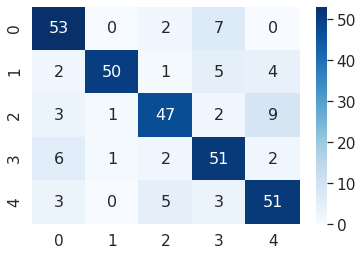

In [ ]:
matriz_confusion(modelo_5)

# Modelo 6 Uso de Red Preentrenado Fine Tunning

Vamos a usar una red **Pre-Entrenada** para implementar el clasificador,
en este caso usaremos la red **VGG16**). Usaremos la técnica de **Fine
Tunning** que nos permite por un lado entrenar las últimas capas de
convolución con nuestras imágenes de entrenamiento y por otro poner la
parte final del clasificador con las capas densamente conectadas, y así
poder obtener una mejor aproximación con nuestras imágenes. Hay que
tener en cuenta que esta red neuronal está pre-entrenada sobre más de 1
millón de imágenes (ttp://www.image-net.org) y categoriza en 1.000
categorías.

Vamos a instanciar una red preentrenada **VGG16** que es una de las
redes que vienen incluidas en Keras.


In [ ]:
# Modelo base
# se descargan los pesos de esta red pre-entrenada para poderla usar
# Indicamos que el input_shape es de 150x150
# No incluimos la parte final include_top = False porque la crearemos  nosotros
modelo_base_vgg16_ft = tf.keras.applications.VGG16( weights='imagenet', input_shape=(150, 150, 3),include_top=False)

Construimos el modelo añadiendo la capa de clasificación que nosotros
necesitamos, además de **congelar (no entrenable)** los parámetros ya entrenados de **VGG16** hasta el bloque llamado **block5_conv3**.

In [ ]:
# Preparamos el modelo base para entrenarlo a partir de las capas que se llaman
# block5_conv3
# Las anteriores no se entrenarán
modelo_base_vgg16_ft.trainable = True
set_trainable = False
for layer in modelo_base_vgg16_ft.layers:
# A partir de esta capa ya se convierte en entrable 
  if layer.name == 'block5_conv3':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
    
# Construimos el modelo, añadiendo nuestra parte final
modelo_6 = keras.Sequential()
modelo_6.add(modelo_base_vgg16_ft)
modelo_6.add(keras.layers.Flatten())
modelo_6.add(keras.layers.Dense(256, activation='relu'))
modelo_6.add(keras.layers.Dense(5, activation='softmax'))
modelo_6.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
modelo_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 4,458,501
Non-trainable params: 12,354,880
_________________________________________________________________


## Entrenamos el modelo

In [ ]:
history_6 = entrena_modelo(modelo_6)

Epoch 1/10
79/79 [==============================] - 27s 330ms/step - loss: 0.9972 - accuracy: 0.6499 - val_loss: 0.6637 - val_accuracy: 0.7387
Epoch 2/10
79/79 [==============================] - 26s 325ms/step - loss: 0.5358 - accuracy: 0.8063 - val_loss: 0.5197 - val_accuracy: 0.8194
Epoch 3/10
79/79 [==============================] - 26s 324ms/step - loss: 0.4673 - accuracy: 0.8321 - val_loss: 0.6336 - val_accuracy: 0.7806
Epoch 4/10
79/79 [==============================] - 26s 324ms/step - loss: 0.3806 - accuracy: 0.8646 - val_loss: 0.5842 - val_accuracy: 0.8032
Epoch 5/10
79/79 [==============================] - 26s 324ms/step - loss: 0.3688 - accuracy: 0.8673 - val_loss: 0.5537 - val_accuracy: 0.8000
Epoch 6/10
79/79 [==============================] - 26s 324ms/step - loss: 0.2850 - accuracy: 0.8990 - val_loss: 0.5136 - val_accuracy: 0.8258
Epoch 7/10
79/79 [==============================] - 26s 325ms/step - loss: 0.2793 - accuracy: 0.8950 - val_loss: 0.5309 - val_accuracy: 0.8677

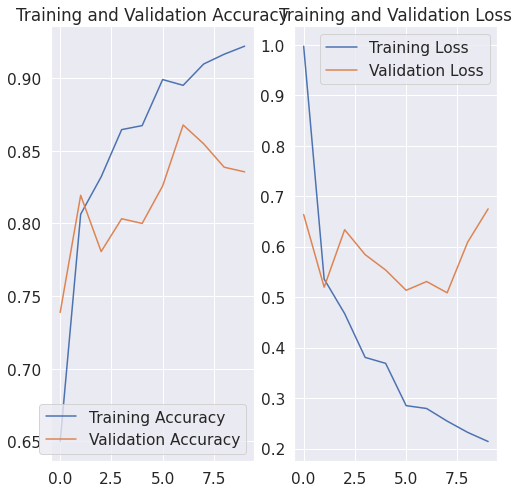

In [ ]:
muestra_historico_entrenamiento(history_6)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [ ]:
guarda_modelo(modelo_6,"modelo_6_flores")

INFO:tensorflow:Assets written to: modelo_6_flores/assets


## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [ ]:
modelo_6 = carga_modelo("modelo_6_flores")
evalua_6 = evalua_modelo(modelo_6)
print(evalua_6)

10/10 [==============================] - 2s 150ms/step - loss: 0.6936 - accuracy: 0.8129
[0.6935875415802002, 0.8129032254219055]


## Matriz de Confusión de los datos de test

Mostramos la matriz de confusión para los datos de test del modelo cargado.

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


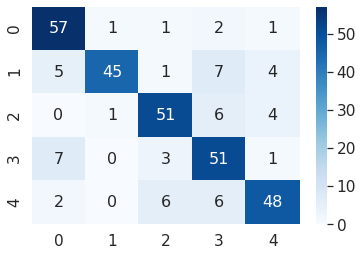

In [ ]:
matriz_confusion(modelo_6)

# Conclusiones

Hemos podido ir viendo con los diferentes modelos desde el más simple al
más complejo, pasando por el uso del Data Augmentation o usando redes
preentrenadas, que hemos conseguido ir mejorando en nuestros resultados
en el **accuracy** en los valores de test. O en algunas ocasiones lo que vemos es que con más **epocas** se podría seguir mejorando ya que la curva en validación es ascendente.

Parece claro que el mejor resultado lo hemos alcanzado con el uso del
**Fine tuning**.

Con esta primera aproximación podríamos intentar afinar más resultados
probando con diferentes **optimizadores** y sus parámetros, con usar un
mayor número de **épocas** de entrenamiento o incluso usar otras
**funciones de activación**.

In [ ]:
print( "Modelo basico")
print(evalua_1)
print( "Modelo incrementando filtros y convoluciones")
print(evalua_2)
print( "Modelo con Dropout y Batchnormalization")
print(evalua_3)
print( "Modelo añadiendo Data Augmentation")
print(evalua_4)
print( "Modelo con redes preentrenadas feature extraction")
print(evalua_5)
print( "Modelo con redes preentranadas fine tuning")
print(evalua_6)

Modelo basico
[2.471039295196533, 0.5967742204666138]
Modelo incrementando filtros y convoluciones
[1.905025601387024, 0.6612903475761414]
Modelo con Dropout y Batchnormalization
[1.281569004058838, 0.6354838609695435]
Modelo añadiendo Data Augmentation
[0.937390148639679, 0.6967741847038269]
Modelo con redes preentrenadas feature extraction
[0.596211850643158, 0.8129032254219055]
Modelo con redes preentranadas fine tuning
[0.6935875415802002, 0.8129032254219055]
